In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader 
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification,
                          RobertaTokenizer,
                          RobertaForSequenceClassification,
                          RobertaConfig,
                          BertTokenizer,
                          BertConfig,
                          BertForSequenceClassification,
                          T5ForConditionalGeneration,
                          T5Config,
                          T5Tokenizer,
                          GPTNeoForSequenceClassification,
                          GPTNeoConfig)

# Set seed for reproducibility.
set_seed(123)

epochs = 2

batch_size = 32

max_length = 50

train_file_path = '/content/CONDA_train.csv'

test_file_path = '/content/CONDA_test.csv'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

labels_ids = {'E': 0, 'I': 1, 'A': 2, 'O': 3}

n_labels = len(labels_ids)

In [ ]:
import os
import io

class CONDADataset(Dataset):

  def __init__(self, path, tokenizer, tokenize, train):

    self.tokenize = tokenize
    self.tokenizer = tokenizer
    self.text = []
    self.labels = []

    self.inputs = []
    self.targets = []

    df = pd.read_csv(path);
    df = df[['utterance', 'intentClass']]
    df = df.dropna()

    #If flag is set, oversample E, I and A
    if train:
      ros = RandomOverSampler(random_state=0)
      df_resampled, y_resampled = ros.fit_resample(df[['utterance']], df[['intentClass']])
      df = pd.concat([df_resampled, y_resampled], axis=1)

    self.text = df['utterance'].to_list()
    self.labels = df['intentClass'].to_list()

    # Number of exmaples.
    self.n_examples = len(self.labels)

    # Tokenize inputs
    if tokenize:
        for i in range(self.n_examples):
      
          self.text[i] += " </s>"
          self.labels[i] += " </s>"

          tokenized_inputs = self.tokenizer.batch_encode_plus([self.text[i]], max_length=512, pad_to_max_length=True, return_tensors="pt")
          tokenized_targets = self.tokenizer.batch_encode_plus([self.labels[i]], max_length=2, pad_to_max_length=True, return_tensors="pt")

          self.inputs.append(tokenized_inputs)
          self.targets.append(tokenized_targets)

    

    return

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return self.n_examples

  def __getitem__(self, item):

    if self.tokenize:
      source_ids = self.inputs[item]["input_ids"].squeeze()
      target_ids = self.targets[item]["input_ids"].squeeze()

      src_mask    = self.inputs[item]["attention_mask"].squeeze() 
      target_mask = self.targets[item]["attention_mask"].squeeze() 

      return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

    else :
      return {'text':self.text[item], 'label':self.labels[item]}



class Gpt2ClassificationCollator(object):

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        labels = [self.labels_encoder[label] for label in labels]
        inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        inputs.update({'labels':torch.tensor(labels)})

        return inputs

In [ ]:
import tensorflow as tf

def train(dataloader, optimizer_, scheduler_, device_):

  # Use global variable for model.
  global model

  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  model.train()

  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    model.zero_grad()

    # Perform a forward pass
    outputs = model(**batch)

    loss, logits = outputs[:2]

    # Accumulate the training loss
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss



def validation(dataloader, device_):

  # Use global variable for model.
  global model

  # Tracking variables
  predictions_labels = []
  true_labels = []
  logits_list = []
  #total loss for this epoch.
  total_loss = 0

  model.eval()

  # Evaluate data for one epoch
  for batch in tqdm(dataloader, total=len(dataloader)):

    # add original labels
    true_labels += batch['labels'].numpy().flatten().tolist()

    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}

    with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(**batch)

        loss, logits = outputs[:2]
      
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        logits_list.append(tf.nn.softmax(logits))

        # Accumulate the training loss
        total_loss += loss.item()
        
        # get predicitons to list
        predict_content = logits.argmax(axis=-1).flatten().tolist()

        # update list
        predictions_labels += predict_content

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)

  # Return all true labels and prediciton for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss, logits_list

In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='gpt2', num_labels=n_labels)

# Get tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Get the model
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='gpt2', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...
Loading tokenizer...
Loading model...


KeyboardInterrupt: ignored

In [ ]:
from transformers import ElectraConfig, ElectraForSequenceClassification, ElectraTokenizerFast

# Get model configuration.
print('Loading configuraiton...')
model_config = ElectraConfig.from_pretrained(pretrained_model_name_or_path='google/electra-base-discriminator', num_labels=n_labels)

# Get tokenizer.
print('Loading tokenizer...')
tokenizer = ElectraTokenizerFast.from_pretrained(pretrained_model_name_or_path='google/electra-base-discriminator')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Get the model
print('Loading model...')
model = ElectraForSequenceClassification.from_pretrained(pretrained_model_name_or_path='google/electra-base-discriminator', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.o

Model loaded to `cuda`


In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = RobertaConfig.from_pretrained(pretrained_model_name_or_path='roberta-base', num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name_or_path='roberta-base')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the model
print('Loading model...')
model = RobertaForSequenceClassification.from_pretrained(pretrained_model_name_or_path='roberta-base', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Model loaded to `cuda`


In [ ]:
# Get model configuration.
print('Loading configuraiton...')
model_config = BertConfig.from_pretrained(pretrained_model_name_or_path='bert-base-uncased', num_labels=n_labels)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path='bert-base-uncased')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


# Get the model
print('Loading model...')
model = BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased', config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)

Loading configuraiton...


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Loading model...


Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded to `cuda`


In [ ]:
import pandas as pd
from imblearn.over_sampling import RandomOverSampler

# Create data collator to encode text and labels into numbers.
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)


# Create pytorch dataset.
train_dataset = CONDADataset(path=train_file_path, tokenizer=tokenizer, tokenize=False, train=False)
print('Created `train_dataset` with %d examples'%len(train_dataset))

# Move pytorch dataset into dataloader.
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)
print('Created `train_dataloader` with %d batches'%len(train_dataloader))

print()

# Create pytorch dataset.
valid_dataset =  CONDADataset(path=test_file_path, tokenizer=tokenizer, tokenize=False, train=False)
print('Created `valid_dataset` with %d examples'%len(valid_dataset))

# Move pytorch dataset into dataloader.
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classificaiton_collator)
print('Created `eval_dataloader` with %d batches'%len(valid_dataloader))

Created `train_dataset` with 26914 examples
Created `train_dataloader` with 842 batches

Created `valid_dataset` with 8973 examples
Created `eval_dataloader` with 281 batches


In [ ]:
optimizer = AdamW(model.parameters(), lr = 5e-5, eps = 1e-8)

total_steps = len(train_dataloader) * 2

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

# Store the average loss after each epoch so we can plot them.
all_loss = {'train_loss':[], 'val_loss':[]}
all_acc = {'train_acc':[], 'val_acc':[]}

# Loop through each epoch.
print('Epoch')
for epoch in tqdm(range(2)):
  print()
  print('Training on batches...')
  # Perform one full pass over the training set.
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)

  # Get prediction form model on validation data. 
  print('Validation on batches...')
  valid_labels, valid_predict, val_loss, logits_list = validation(valid_dataloader, device)
  val_acc = accuracy_score(valid_labels, valid_predict)

  # Print loss and accuracy values to see how training evolves.
  print("  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - valid_acc: %.5f"%(train_loss, val_loss, train_acc, val_acc))
  print()

  # Store the loss value for plotting the learning curve.
  all_loss['train_loss'].append(train_loss)
  all_loss['val_loss'].append(val_loss)
  all_acc['train_acc'].append(train_acc)
  all_acc['val_acc'].append(val_acc)

Epoch


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/842 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/281 [00:00<?, ?it/s]

  train_loss: 0.55586 - val_loss: 0.36330 - train_acc: 0.83269 - valid_acc: 0.90371


Training on batches...


  0%|          | 0/842 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/281 [00:00<?, ?it/s]

  train_loss: 0.32115 - val_loss: 0.32896 - train_acc: 0.91529 - valid_acc: 0.91630



  0%|          | 0/281 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           E      0.882     0.838     0.859      1183
           I      0.937     0.586     0.721       582
           A      0.791     0.752     0.771       580
           O      0.931     0.974     0.952      6628

    accuracy                          0.916      8973
   macro avg      0.885     0.787     0.826      8973
weighted avg      0.916     0.916     0.913      8973



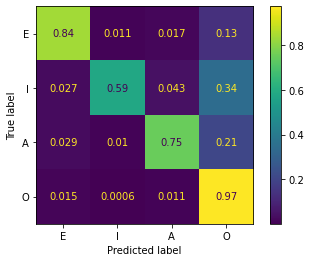

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

true_labels, predictions_labels, avg_epoch_loss, logits_list = validation(valid_dataloader, device)

#print(logits_list)
#print(true_labels)

# Get eval report with P, R and F1 scores
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=list(labels_ids.keys()), digits=3)
print(evaluation_report)

# Create confusion matrix image
cm = confusion_matrix(y_true=true_labels, y_pred=predictions_labels, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_ids)
disp.plot()

In [ ]:
import numpy as np

probs = []

# Get probabilites for PR curve
for i in range(len(logits_list)):
  temp = logits_list[i].numpy()
  for j in range(len(temp)):
    probs.append(temp[j].tolist())

probs = np.array(probs)
print(probs)

[[0.00163914 0.00193492 0.00163092 0.99479502]
 [0.00163746 0.00194701 0.00163578 0.99477971]
 [0.0119856  0.01120995 0.01435542 0.96244907]
 ...
 [0.00167534 0.0018941  0.00163955 0.99479103]
 [0.93309492 0.00844772 0.00396334 0.054494  ]
 [0.01313527 0.01268888 0.01513105 0.95904475]]


In [ ]:
from sklearn.preprocessing import label_binarize

# Binarize 
Y_test = label_binarize(true_labels, classes=[0, 1, 2, 3])
print(Y_test)

[[0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 ...
 [0 0 0 1]
 [1 0 0 0]
 [0 0 0 1]]


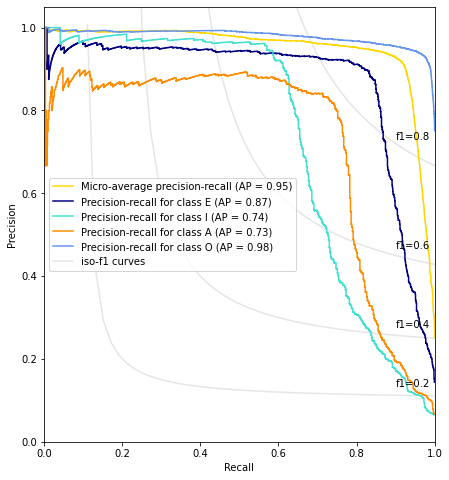

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay
from itertools import cycle

c = ['E', 'I', 'A', 'O']
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(4):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], probs[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], probs[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), probs.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, probs, average="micro")

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

# Plot iso-f1 curves
f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

# Get PR curves
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(4), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class " + c[i], color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
plt.show()

In [ ]:
import numpy as np

# Dummy input
dummy_input = tokenizer.encode("wow thats crazy", max_length=512, pad_to_max_length=True, return_tensors="pt").to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))

# Warm up GPU
for _ in range(10):
   _ = model(dummy_input)
# Measure time
with torch.no_grad():
  for rep in range(repetitions):
     starter.record()
     _ = model(dummy_input)
     ender.record()
     # Sync GPU
     torch.cuda.synchronize()
     curr_time = starter.elapsed_time(ender)
     timings[rep] = curr_time

# Calculate inference time
mean_syn = np.sum(timings) / repetitions
std_syn = np.std(timings)
print(mean_syn)

37.005681368509926


In [ ]:
# Dummy input
dummy_input = tokenizer.encode("wow thats crazy", max_length=512, pad_to_max_length=True, return_tensors="pt").to(device)
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 300
timings=np.zeros((repetitions,1))
repetitions=100
total_time = 0

with torch.no_grad():
  for rep in range(repetitions):
     starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
     starter.record()
     _ = model(dummy_input)
     ender.record()
     # Sync GPU
     torch.cuda.synchronize()
     curr_time = starter.elapsed_time(ender)/1000
     total_time += curr_time

# Calculate throughput using batch size
Throughput = (repetitions*8)/total_time
print('Final Throughput:',Throughput)

Final Throughput: 212.2574101856548
